# From the beginning

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/male_players (legacy).csv")

# View the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Impute missing values or drop irrelevant columns
df.fillna(method='ffill', inplace=True)

# Save cleaned data
df.to_csv("cleaned_dataset.csv", index=False)


<ipython-input-2-428aabeab5c9>:4: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/male_players (legacy).csv")


   player_id                                        player_url  fifa_version  \
0     158023                /player/158023/lionel-messi/150002            15   
1      20801  /player/20801/c-ronaldo-dos-santos-aveiro/150002            15   
2       9014                  /player/9014/arjen-robben/150002            15   
3      41236           /player/41236/zlatan-ibrahimovic/150002            15   
4     167495                /player/167495/manuel-neuer/150002            15   

   fifa_update fifa_update_date         short_name  \
0            2       2014-09-18           L. Messi   
1            2       2014-09-18  Cristiano Ronaldo   
2            2       2014-09-18          A. Robben   
3            2       2014-09-18     Z. Ibrahimović   
4            2       2014-09-18           M. Neuer   

                             long_name player_positions  overall  potential  \
0       Lionel Andrés Messi Cuccittini               CF       93         95   
1  Cristiano Ronaldo dos Santos Avei

<ipython-input-2-428aabeab5c9>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
rating_cols = ['cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

for col in rating_cols:
    # Replace NaN values with a default string (e.g., '0+0')
    df[col] = df[col].fillna('0+0')

    # Normalize '-' to '+' for consistent splitting
    normalized_col = df[col].str.replace('-', '+', regex=False)

    # Split into base and bonus parts
    df[[f"{col}_base", f"{col}_bonus"]] = normalized_col.str.split('+', expand=True).fillna(0).astype(int)

# Drop the original rating columns if only base values are needed
df.drop(columns=rating_cols, inplace=True)

# View the updated dataframe
print(df.head())


   player_id                                        player_url  fifa_version  \
0     158023                /player/158023/lionel-messi/150002            15   
1      20801  /player/20801/c-ronaldo-dos-santos-aveiro/150002            15   
2       9014                  /player/9014/arjen-robben/150002            15   
3      41236           /player/41236/zlatan-ibrahimovic/150002            15   
4     167495                /player/167495/manuel-neuer/150002            15   

   fifa_update fifa_update_date         short_name  \
0            2       2014-09-18           L. Messi   
1            2       2014-09-18  Cristiano Ronaldo   
2            2       2014-09-18          A. Robben   
3            2       2014-09-18     Z. Ibrahimović   
4            2       2014-09-18           M. Neuer   

                             long_name player_positions  overall  potential  \
0       Lionel Andrés Messi Cuccittini               CF       93         95   
1  Cristiano Ronaldo dos Santos Avei

In [6]:
# One-hot encode the player_positions column
positions_encoded = df['player_positions'].str.get_dummies(sep=', ')

# Add the one-hot encoded columns back to the dataframe
df = pd.concat([df, positions_encoded], axis=1)

# Drop the original player_positions column
df.drop(columns=['player_positions'], inplace=True)

# Display updated dataframe
print(df.head())


   player_id                                        player_url  fifa_version  \
0     158023                /player/158023/lionel-messi/150002            15   
1      20801  /player/20801/c-ronaldo-dos-santos-aveiro/150002            15   
2       9014                  /player/9014/arjen-robben/150002            15   
3      41236           /player/41236/zlatan-ibrahimovic/150002            15   
4     167495                /player/167495/manuel-neuer/150002            15   

   fifa_update fifa_update_date         short_name  \
0            2       2014-09-18           L. Messi   
1            2       2014-09-18  Cristiano Ronaldo   
2            2       2014-09-18          A. Robben   
3            2       2014-09-18     Z. Ibrahimović   
4            2       2014-09-18           M. Neuer   

                             long_name  overall  potential    value_eur  ...  \
0       Lionel Andrés Messi Cuccittini       93         95  100500000.0  ...   
1  Cristiano Ronaldo dos Santos Av

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns to normalize
numerical_cols = ['overall', 'potential'] + [col for col in df.columns if col.endswith('_base')]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display normalized numerical features
print(df[numerical_cols].head())


    overall  potential  cdm_base  rdm_base  rwb_base   lb_base  lcb_base  \
0  0.981481   1.000000  0.652778  0.652778  0.648649  0.555556  0.405405   
1  0.962963   0.945455  0.666667  0.666667  0.662162  0.597222  0.500000   
2  0.925926   0.909091  0.680556  0.680556  0.675676  0.569444  0.418919   
3  0.925926   0.909091  0.694444  0.694444  0.635135  0.583333  0.540541   
4  0.925926   0.909091  0.347222  0.347222  0.297297  0.305556  0.310811   

    cb_base  rcb_base   rb_base   gk_base  
0  0.405405  0.405405  0.555556  0.166667  
1  0.500000  0.500000  0.597222  0.177778  
2  0.418919  0.418919  0.569444  0.155556  
3  0.540541  0.540541  0.583333  0.188889  
4  0.310811  0.310811  0.305556  0.966667  


In [8]:
import numpy as np

# Define the sequence length for LSTM
sequence_length = 5

# Create sequences for LSTM
def create_lstm_sequences(data, features, seq_len):
    sequences, labels = [], []
    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i+seq_len][features].values
        label = data.iloc[i+seq_len]['overall']  # Use 'overall' as target, replace if needed
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define LSTM features
lstm_features = ['overall', 'potential'] + [col for col in df.columns if col.endswith('_base')]

# Generate sequences and labels
lstm_sequences, lstm_labels = create_lstm_sequences(df, lstm_features, sequence_length)

# Check sequence shape
print("LSTM Sequences Shape:", lstm_sequences.shape)
print("LSTM Labels Shape:", lstm_labels.shape)


LSTM Sequences Shape: (161578, 5, 11)
LSTM Labels Shape: (161578,)


In [10]:
# List all columns in the dataset
print(df.columns)


Index(['player_id', 'player_url', 'fifa_version', 'fifa_update',
       'fifa_update_date', 'short_name', 'long_name', 'overall', 'potential',
       'value_eur',
       ...
       'GK', 'LB', 'LM', 'LW', 'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST'],
      dtype='object', length=133)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Generate radar charts for visual data
def create_radar_chart(data, player_name, output_path):
    # Define the attributes to visualize
    attributes = ['overall', 'potential', 'value_eur', 'wage_eur', 'pace', 'shooting']  # Replace with existing columns

    # Check if all attributes exist in the dataset
    missing_attrs = [attr for attr in attributes if attr not in data.columns]
    if missing_attrs:
        print(f"The following attributes are missing: {missing_attrs}")
        return

    # Filter data for the specific player
    player_data = data[data['short_name'] == player_name]

    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return

    # Extract attribute values for the player
    values = player_data[attributes].iloc[0].tolist()
    values += values[:1]  # Close the radar chart

    # Define angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
    angles += angles[:1]

    # Create the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)
    ax.set_title(player_name, size=20)

    # Save the chart
    plt.savefig(output_path)
    plt.close()

# Example usage
create_radar_chart(df, "L. Messi", "lionel_messi_radar.png")


In [12]:
from sklearn.model_selection import train_test_split

# Split LSTM data
lstm_train, lstm_test, y_train, y_test = train_test_split(
    lstm_sequences, lstm_labels, test_size=0.2, random_state=42
)

# Verify shapes
print("Training Data Shape:", lstm_train.shape)
print("Testing Data Shape:", lstm_test.shape)


Training Data Shape: (129262, 5, 11)
Testing Data Shape: (32316, 5, 11)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lstm_train.shape[1], lstm_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    lstm_train,
    y_train,
    epochs=10,  # Adjust epochs as needed
    batch_size=32,
    validation_split=0.2  # Use 20% of training data for validation
)


Epoch 1/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0037 - mae: 0.0315 - val_loss: 0.0011 - val_mae: 0.0305
Epoch 2/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 1.9883e-04 - mae: 0.0084 - val_loss: 0.0018 - val_mae: 0.0377
Epoch 3/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.3825e-04 - mae: 0.0062 - val_loss: 0.0024 - val_mae: 0.0467
Epoch 4/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 7.9720e-05 - mae: 0.0049 - val_loss: 0.0029 - val_mae: 0.0493
Epoch 5/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 9.8342e-05 - mae: 0.0043 - val_loss: 0.0026 - val_mae: 0.0463
Epoch 6/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 7.2258e-05 - mae: 0.0038 - val_loss: 0.0033 - val_mae: 0.0528
Epoch 7/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 6.3832e-05 - mae: 0.0036 - val_loss: 0.0038 - val_mae: 0.0574
Epoch 8/10
3232/3232 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 7.9142e-05 - mae: 0.0036 - val_loss: 0.0041 - val_mae: 0.0596
Epoc

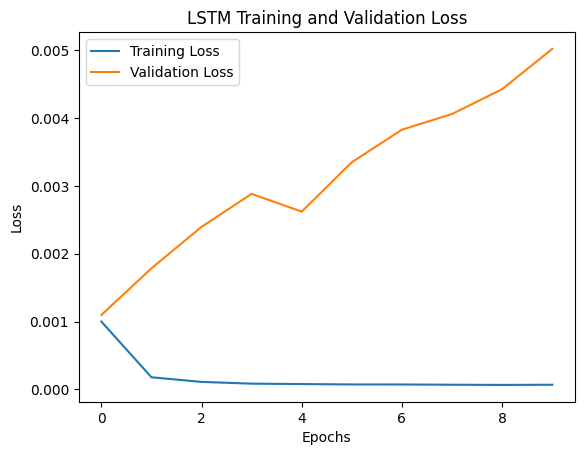

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(lstm_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")


1010/1010 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - mae: 0.0662
Test Loss: 0.004943015985190868
Test Mean Absolute Error (MAE): 0.06611187756061554


In [20]:
# Make predictions
predictions = model.predict(lstm_test)

# Display a sample of predictions and true values
for i in range(5):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {y_test[i]:.2f}")


1010/1010 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Predicted: 0.43, Actual: 0.50
Predicted: 0.61, Actual: 0.72
Predicted: 0.52, Actual: 0.61
Predicted: 0.38, Actual: 0.44
Predicted: 0.63, Actual: 0.74


In [19]:
# Save the model using the recommended Keras format
model.save("lstm_player_model.keras")



In [21]:
# Create and write Streamlit app code into a file named "app.py"
streamlit_code = """
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("lstm_player_model.keras")

# App title and description
st.title("FIFA Player Performance Prediction")
st.write("Predict a player's performance or transfer value based on their attributes.")

# Input fields for player attributes
st.sidebar.header("Player Attributes")
overall = st.sidebar.slider("Overall", min_value=0, max_value=100, value=75)
potential = st.sidebar.slider("Potential", min_value=0, max_value=100, value=80)

# Add more features as needed
pace = st.sidebar.slider("Pace", min_value=0, max_value=100, value=70)
shooting = st.sidebar.slider("Shooting", min_value=0, max_value=100, value=65)
dribbling = st.sidebar.slider("Dribbling", min_value=0, max_value=100, value=75)

# Create a time-series sequence for prediction (dummy example)
sequence_length = 5
lstm_features = [overall, potential, pace, shooting, dribbling]
sequence = np.tile(lstm_features, (sequence_length, 1))  # Repeat the input for a fixed sequence length

# Reshape input for LSTM
sequence = sequence.reshape(1, sequence_length, len(lstm_features))

# Predict using the model
if st.button("Predict"):
    prediction = model.predict(sequence)
    st.write(f"Predicted Value: {prediction[0][0]:.2f}")
"""

# Write the code to "app.py"
with open('/content/app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app code has been saved as 'app.py'.")


Streamlit app code has been saved as 'app.py'.


In [22]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00
